Denoising Image using Autoencoders

In [1]:
!pip install wandb einops pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 21.9 MB/s 
     |████████████████████████████████| 585 kB 70.1 MB/s 
     |████████████████████████████████| 181 kB 66.7 MB/s 
     |████████████████████████████████| 153 kB 63.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 419 kB 67.4 MB/s 
     |████████████████████████████████| 140 kB 75.7 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 77.6 MB/s 
     |████████████████████████████████| 271 kB 69.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8bfdea1ca5a3c90ccdec0c2c532d1ed90e6c3978cc455af60dc3da8b95dbeb72
  Stored in directory: /root/.cache/pip/wheels/3e/31/0

In [2]:
import torch
import torchvision
import wandb
import time

from torch import nn
from einops import rearrange, reduce
from argparse import ArgumentParser
from pytorch_lightning import LightningModule, Trainer, Callback
from pytorch_lightning.loggers import WandbLogger
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, n_features=3, kernel_size=3, n_filters=16, feature_dim=1024):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        self.fc1 = nn.Linear(576, feature_dim)
       

    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = rearrange(y, 'b c h w -> b (c h w)')

        y = self.fc1(y)
        return y




# use this to get the correct input shape for  fc1. 
encoder = Encoder(n_features=3)
x = torch.Tensor(1, 3, 32, 32)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 1024])


Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=64, feature_dim=1024, output_size=32, output_channels=3):
        super().__init__()
        self.init_size = output_size // 2**2 
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        # output size of conv2dtranspose is (h-1)*2 + 1 + (kernel_size - 1)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, n_filters//4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size+1)
        
    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = rearrange(y, 'b (c h w) -> b c h w', b=B, h=self.init_size, w=self.init_size)
        y = nn.ReLU()(self.conv1(y))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = nn.Sigmoid()(self.conv4(y))

        return y
decoder = Decoder()
x_tilde = decoder(h)
print("x_tilde.shape:", x_tilde.shape)

x_tilde.shape: torch.Size([1, 3, 32, 32])


pytorch lightning autoencoder

In [5]:
def noise_collate_fn(batch):
        x, _ = zip(*batch)
        x = torch.stack(x, dim=0)
        # mean=0.5, std=0.5 normal noise
        noise = torch.normal(0.5, 0.5, size=x.shape)
        xn = x + noise
        xn = torch.clamp(xn, 0, 1)
        return xn, x


class DenoiseCIFAR100Model(LightningModule):
  
    def __init__(self, feature_dim=256, lr=0.001, batch_size=64,
                 num_workers=2, max_epochs=30, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    # this is called during fit()
    def training_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        return {"loss": loss}

    # calls to self.log() are recorded in wandb
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_loss", avg_loss, on_epoch=True)

    # this is called at the end of an epoch
    def test_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        return {"x_in" : x_in, "x": x, "x_tilde" : x_tilde, "test_loss" : loss,}

    # this is called at the end of all epochs
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    # validation is the same as test
    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self.test_epoch_end(outputs)

    # we use Adam optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler], 
    
    # this is called after model instatiation to initiliaze the datasets and dataloaders
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # build train and test dataloaders using MNIST dataset
    # we use simple ToTensor transform
    def train_dataloader(self):     
         return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR100(
                "./data", train=True, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=noise_collate_fn
        )

    def test_dataloader(self):
       return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR100(
                "./data", train=False, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=noise_collate_fn
        )


    def val_dataloader(self):
        return self.test_dataloader()

In [7]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning Denoise CIFAR100")
    parser.add_argument("--max-epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--feature-dim", type=int, default=256, help="ae feature dimension")

    parser.add_argument("--devices", default=1)
    parser.add_argument("--accelerator", default='gpu')
    parser.add_argument("--num-workers", type=int, default=2, help="num workers")
    
    args = parser.parse_args("")
    return args

In [ ]:
if __name__ == "__main__":
    args = get_args()
    ae = DenoiseCIFAR100Model(feature_dim=args.feature_dim, lr=args.lr, 
                                 batch_size=args.batch_size, num_workers=args.num_workers,
                                 max_epochs=args.max_epochs)
    #ae.setup()

   # wandb_logger = WandbLogger(project="colorize-cifar10")
    start_time = time.time()
    trainer = Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.max_epochs,
                     #logger=wandb_logger
                      #callbacks=[WandbCallback()]
                      )
    trainer.fit(ae)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(elapsed_time))

    wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 171 K 
1 | decoder | Decoder | 1.1 M 
2 | loss    | MSELoss | 0     
------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Elapsed time: 540.3194899559021


Testing the Model

In [28]:
#get sample image from testloader
testload= torch.utils.data.DataLoader(torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=torchvision.transforms.ToTensor()),
            batch_size=1,
            shuffle=True,
            pin_memory=True,
            collate_fn=noise_collate_fn
        )


load2=next(iter(testload))

Files already downloaded and verified


Save image to Jpeg (from tensor to array to Jpeg)


In [ ]:
from PIL import Image
import numpy as np

imj=load2[0][0].permute(1, 2, 0)
imj = imj.numpy()
from PIL import Image
im = Image.fromarray((imj * 255).astype(np.uint8))
im.save("outside.jpeg")

Text(0.5, 1.0, 'original')

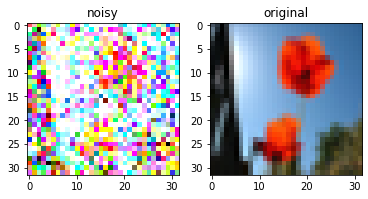

In [29]:

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(load2[0][0].permute(1, 2, 0))
plt.title('noisy')
plt.subplot(1,2,2)
plt.imshow(load2[1][0].permute(1, 2, 0))
plt.title('original')

Make predictions

In [48]:
# decoder as a generative model
import matplotlib.pyplot as plt

modelchek = DenoiseCIFAR100Model.load_from_checkpoint("/content/epoch=29-step=23460_latest.ckpt")
decoder = modelchek.decoder
encoder = modelchek.encoder
enc = encoder(load2[0])

decoder.eval()
with torch.no_grad():
    # generate a tensor of random noise with size 1, feature_dim
   # x_in = torch.randn(1, args.feature_dim)
   # y = rearrange(load2[0], 'b c h w -> b (c h w)')
    x_tilde = decoder.forward(enc)
    #plt.imshow(x_tilde[0].detach().numpy().reshape(32, 32))
    #plt.axis('off')
    #plt.show()

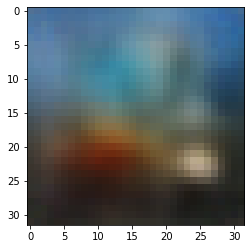

In [49]:
plt.imshow(x_tilde[0].permute(1, 2, 0))

Text(0.5, 1.0, 'processed')

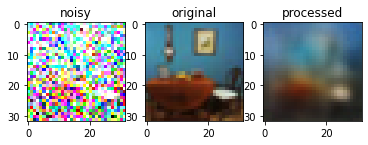

In [50]:
plt.subplot(1,3,1)
plt.imshow(load2[0][0].permute(1, 2, 0))
plt.title('noisy')
plt.subplot(1,3,2)
plt.imshow(load2[1][0].permute(1, 2, 0))
plt.title('original')
plt.subplot(1,3,3)
plt.imshow(x_tilde[0].permute(1, 2, 0))
plt.title("processed")

Text(0.5, 1.0, 'processed')

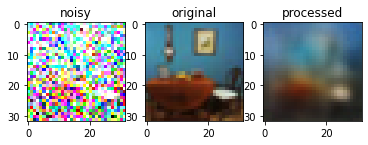

In [51]:

import matplotlib.pyplot as plt

modelcheck = DenoiseCIFAR100Model.load_from_checkpoint("/content/epoch=29-step=23460_latest.ckpt")
modelcheck=modelcheck.eval()
with torch.no_grad():
    x_tilde = modelcheck(load2[0])



plt.subplot(1,3,1)
plt.imshow(load2[0][0].permute(1, 2, 0))
plt.title('noisy')
plt.subplot(1,3,2)
plt.imshow(load2[1][0].permute(1, 2, 0))
plt.title('original')
plt.subplot(1,3,3)
plt.imshow(x_tilde[0].permute(1, 2, 0))
plt.title("processed")